In [1]:
!pip install matplotlib

In [2]:
!python -m pip install --upgrade pip

In [3]:
!pip install tensorflow

In [4]:
!pip install setuptools

In [5]:
!pip install --upgrade setuptools pip

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [7]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [8]:
# Create a Classifier class

class Classifier:
    def __init__(self):
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [9]:
class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        super().__init__()  # Call parent class initializer without arguments
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss='mean_squared_error',
                           metrics=['accuracy'])
    
    def init_model(self):
        image_dimensions = {
            'height': 256,
            'width': 256,
            'channels': 3
        }
        
        x = Input(shape=(image_dimensions['height'],
                         image_dimensions['width'],
                         image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

    def load(self, weights_path):
        self.model.load_weights(weights_path)

In [10]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF.h5')

C:\Users\91993\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [12]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Predicted likelihood: 0.8552
Actual label: 1
Correct prediction: True


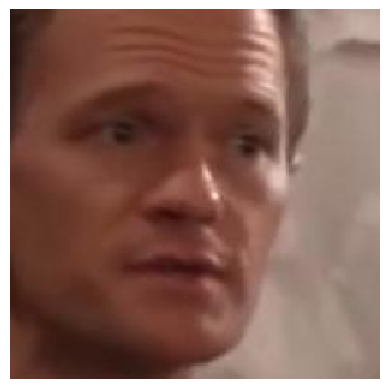

In [13]:
# Rendering image X with label y for MesoNet
X, y = next(generator)

# Evaluating prediction
predicted_likelihood = meso.predict(X)[0][0]
print(f"Predicted likelihood: {predicted_likelihood:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"Correct prediction: {round(predicted_likelihood) == y[0]}")

# Showing image using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(X))
plt.axis('off')  # Remove axis labels
plt.show()


In [14]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [15]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = next(generator)
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status updat
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0  predictions completed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [16]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

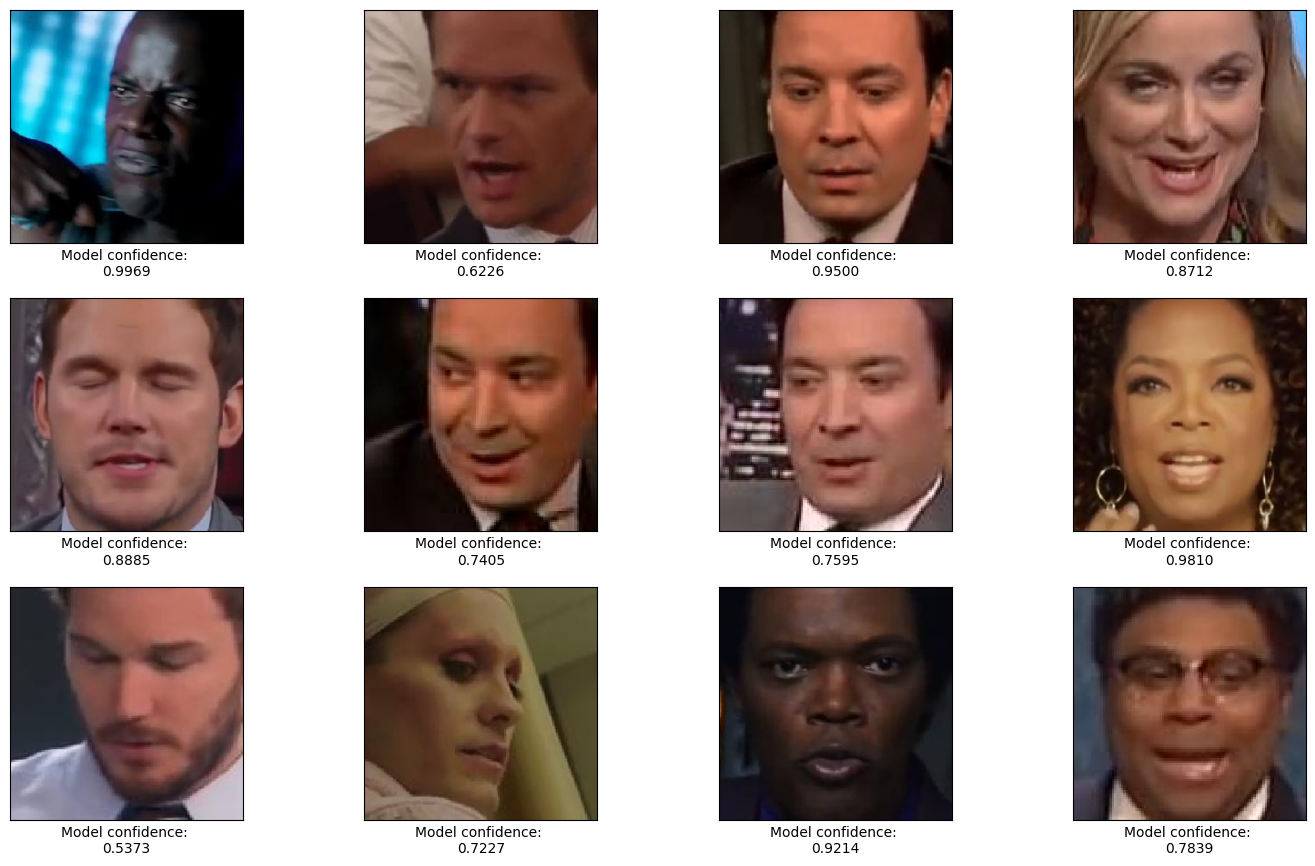

In [17]:
plotter(correct_real, correct_real_pred)

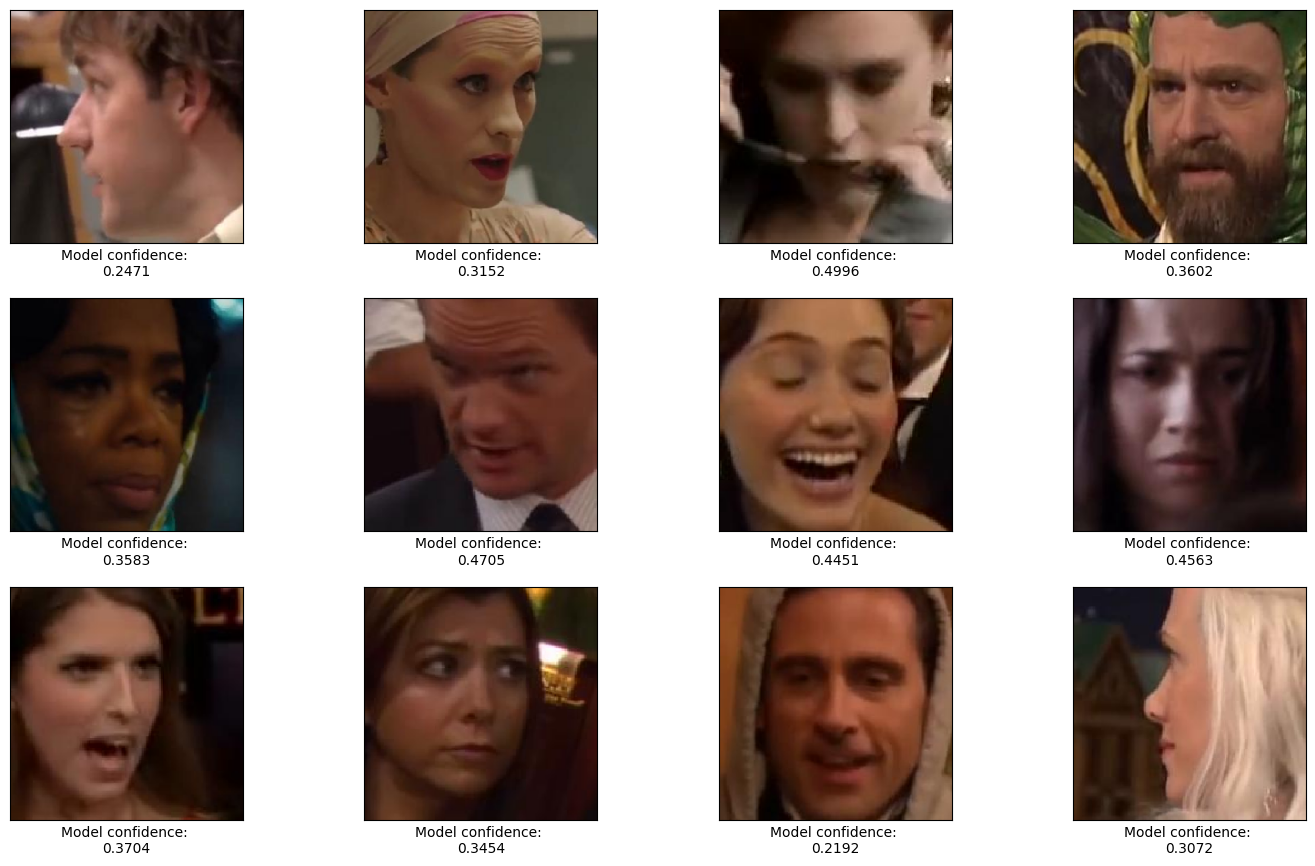

In [18]:
plotter(misclassified_real, misclassified_real_pred)

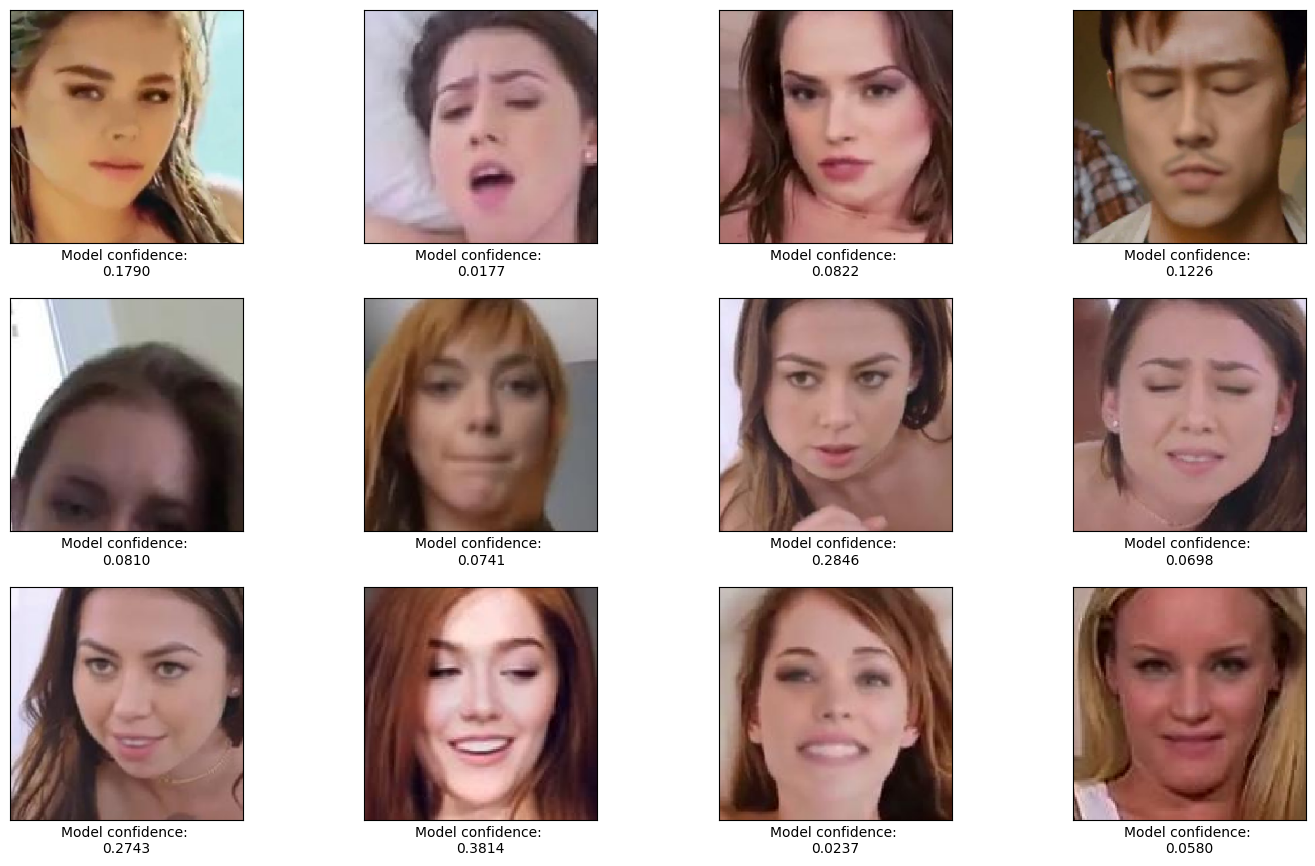

In [19]:
plotter(correct_deepfake, correct_deepfake_pred)

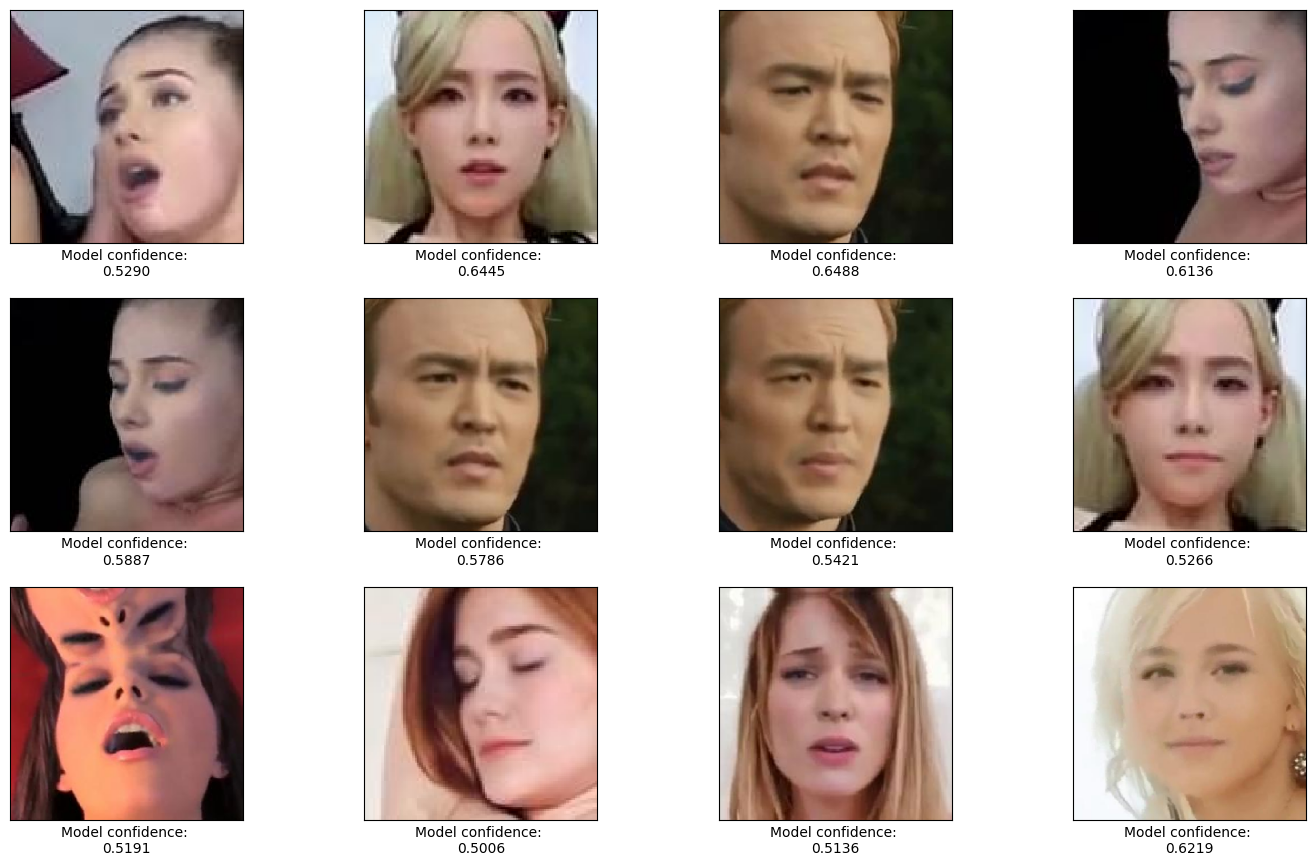

In [20]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)